In [1]:
project_name = 'dhcp'
import os
#get current working directory
cwd = os.getcwd()
git_dir = cwd.split(project_name)[0] + project_name
import sys

#add git_dir to path
sys.path.append(git_dir)
from nilearn import plotting, image
import numpy as np
import nibabel as nib
import dhcp_params as params
import pandas as pd
from nilearn.maskers import NiftiMasker
from glob import glob as glob
from nilearn.maskers import MultiNiftiMasker
from nilearn.maskers import NiftiLabelsMasker
import dhcp_params as params
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
group = 'infant'
atlas = 'wang'
age_bins = [26,33, 38,42,46]
age_groups = ['pre','early','term','post']
group_params = params.load_group_params(group)
adult_params = params.load_group_params('adult')
sub_list = pd.read_csv(f'{git_dir}/participants_dhcp.csv')
subs2analyze = sub_list[(sub_list[f'{atlas}_exclude'] != 1) & (sub_list[f'{atlas}_ts'] == 1)]
print(len(sub_list))

#remove subs where scan_age < birth_age
sub_list = sub_list[sub_list['scan_age']>sub_list['birth_age']]

sub_list = sub_list.reset_index()


sub_list['age'] = sub_list['scan_age'] - sub_list['birth_age']*7
sub_list['age_group'] = np.nan

for i in range(len(age_bins)-1):
    sub_list.loc[(sub_list['scan_age'] >= age_bins[i]) & (sub_list['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]

#save
#sub_list.to_csv('participants_dhcp.csv', index = False)

736


/tmp/ipykernel_2845019/3799880274.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'pre' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  sub_list.loc[(sub_list['scan_age'] >= age_bins[i]) & (sub_list['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]


In [3]:
sub='sub-CC00284AN13'
ses='ses-90701'
atlas = 'wang'

func_1vol = image.load_img(f'{group_params.out_dir}/{sub}/{ses}/func/{sub}_{ses}_{group_params.func_suf}_1vol.nii.gz')
#full_func = image.load_img(f'{group_params.raw_func_dir}/{sub}/{ses}/func/{sub}_{ses}_{group_params.func_suf}.nii.gz')

brain_mask = image.load_img(f'{group_params.out_dir}/{sub}/{ses}/anat/{sub}_{ses}_desc-ribbon_dseg_epi.nii.gz')


anat = image.load_img(f'{group_params.out_dir}/{sub}/{ses}/anat/{sub}_{ses}_desc-restore_T2w_brain.nii.gz')
dwi = image.load_img(f'{group_params.out_dir}/{sub}/{ses}/dwi/nodif.nii.gz')

'''

roi = image.load_img(f'{group_params.out_dir}/{sub}/{ses}/rois/wang/lh_V1v_dwi.nii.gz')
seed = image.load_img(f'{group_params.out_dir}/{sub}/{ses}/rois/pulvinar/lh_pulvinar_dwi.nii.gz')


exclusion_mask = image.load_img(f'{group_params.out_dir}/{sub}/{ses}/rois/exclusionmasks/exclusion_allmasks_rh.nii.gz')
waypoint_mask = image.load_img(f'{group_params.out_dir}/{sub}/{ses}/rois/waypointmasks/V1_lh_waypoint_mask_dwispace.nii.gz')


atlas = image.load_img(f'{group_params.out_dir}/{sub}/{ses}/atlas/Wang_maxprob_surf_lh_edits_dwi_bin.nii.gz')
bedpost_file = image.load_img(f'{group_params.out_dir}/{sub}/{ses}/dwi_bedpostx.bedpostX/mean_f2samples.nii.gz')
'''

"\n\nroi = image.load_img(f'{group_params.out_dir}/{sub}/{ses}/rois/wang/lh_V1v_dwi.nii.gz')\nseed = image.load_img(f'{group_params.out_dir}/{sub}/{ses}/rois/pulvinar/lh_pulvinar_dwi.nii.gz')\n\n\nexclusion_mask = image.load_img(f'{group_params.out_dir}/{sub}/{ses}/rois/exclusionmasks/exclusion_allmasks_rh.nii.gz')\nwaypoint_mask = image.load_img(f'{group_params.out_dir}/{sub}/{ses}/rois/waypointmasks/V1_lh_waypoint_mask_dwispace.nii.gz')\n\n\natlas = image.load_img(f'{group_params.out_dir}/{sub}/{ses}/atlas/Wang_maxprob_surf_lh_edits_dwi_bin.nii.gz')\nbedpost_file = image.load_img(f'{group_params.out_dir}/{sub}/{ses}/dwi_bedpostx.bedpostX/mean_f2samples.nii.gz')\n"


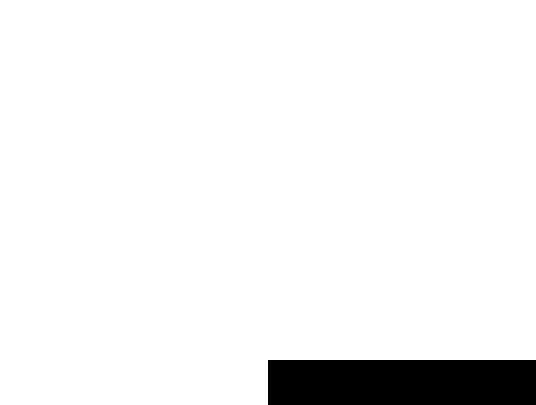
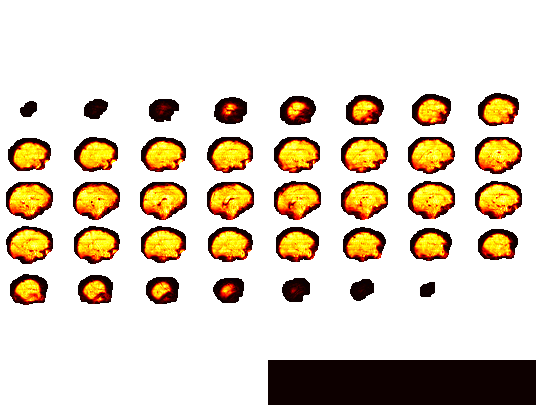

In [4]:
plotting.view_img(func_1vol, bg_img=None,title = 'func_1vol')

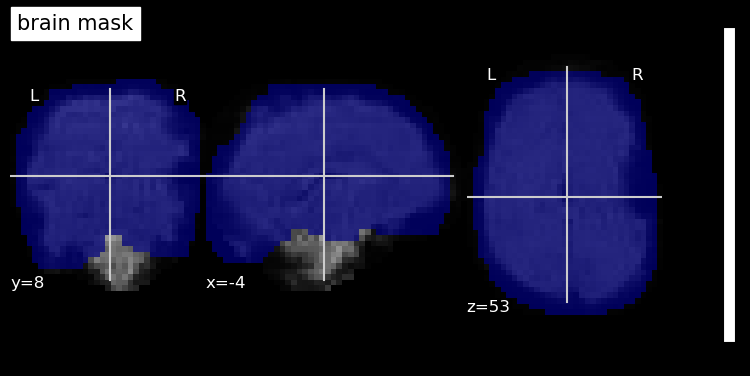

In [55]:
plotting.plot_roi(brain_mask, bg_img=func_1vol, title = 'brain mask', colorbar=True)

In [14]:
#extract data from brain mask
masker = NiftiMasker(mask_img=brain_mask)
brain_data = masker.fit_transform(func_1vol)
print(brain_data.shape)
#flatten the data
brain_data = brain_data.flatten()

#compute 95% confidence intervals for the brain_data values using np.percentile
ci_low = np.percentile(brain_data, 2.5)
ci_high = np.percentile(brain_data, 97.5)

sd = np.std(brain_data)
mean = np.mean(brain_data)
sd_low = mean - (sd*1)



(1, 34673)


In [15]:
#func_1vol = image.load_img(f'{group_params.out_dir}/{sub}/{ses}/func/{sub}_{ses}_{group_params.func_suf}_1vol.nii.gz')
#brain_data= func_1vol.get_fdata()
brain_data = masker.fit_transform(func_1vol)


print(np.min(brain_data))


#set all other values to 0
#brain_data[brain_data >= ci_low] = 0
brain_data[brain_data <= sd_low] = 1

#set any data not 1 to 0
brain_data[brain_data != 1] = 0


print(np.max(brain_data))

#reshape the data back to the original shape
drop_out = masker.inverse_transform(brain_data)

#convert back to nifti
#drop_out = nib.Nifti1Image(brain_data, func_1vol.affine, func_1vol.header)

-3.291923
1.0


/home/vayzenb/anaconda3/envs/fmri/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



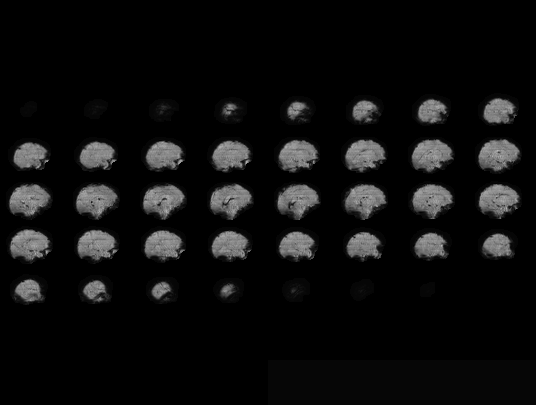
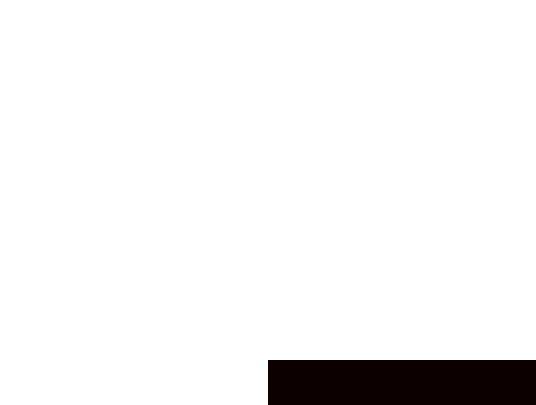

In [16]:
plotting.view_img(drop_out, bg_img=func_1vol, title = 'drop out', colorbar=True)

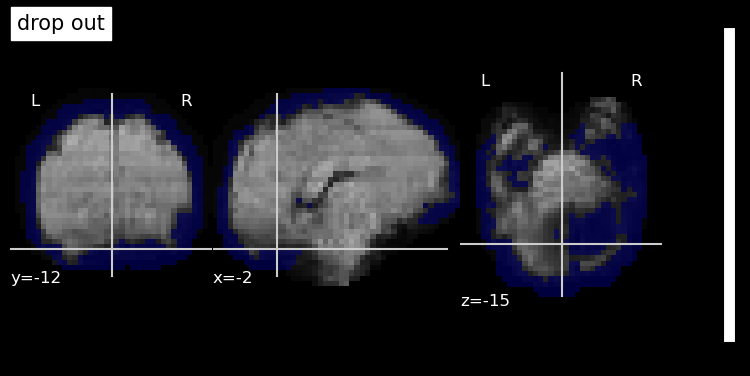

In [18]:
plotting.plot_roi(drop_out, bg_img=func_1vol, title = 'drop out', colorbar=True, cut_coords=[-2, -12, -15], alpha=0.5)

In [71]:
df_summary = pd.read_csv(f'{group_params.out_dir}/derivatives/{atlas}/infant_adult_{atlas}_correlations.csv')

#only include subs that are in subs2analyze
df_summary = df_summary[df_summary['sub'].isin(subs2analyze['participant_id'])]

#add age column
df_summary['age'] = (df_summary['scan_age'] - df_summary['birth_age']) * 7

#add age group column
df_summary['age_group'] = np.nan
for i in range(len(age_bins)-1):
    df_summary.loc[(df_summary['scan_age'] >= age_bins[i]) & (df_summary['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]

#load infant noise ceiliing
infant_noise = pd.read_csv(f'{group_params.out_dir}/derivatives/noise_ceiling/infant_{atlas}_split_half_reliability.csv')
adult_noise = pd.read_csv(f'{adult_params.out_dir}/derivatives/noise_ceiling/adult_{atlas}_split_half_reliability.csv')

/tmp/ipykernel_931992/1481528434.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'pre' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_summary.loc[(df_summary['scan_age'] >= age_bins[i]) & (df_summary['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]


In [72]:
#extract data where roi1 is V1v or V1d and roi2 is V1v or V1d
df_roi = df_summary[(df_summary['infant_roi'].isin(['V1v', 'V1d'])) & (df_summary['adult_roi'].isin(['V1v', 'V1d']))]

#extract where infant and adult network are occipital
#df_roi = df_summary[(df_summary['infant_network'] == 'Occipital') & (df_summary['adult_network'] == 'Occipital')]

#extra hemi_similarity == diff
df_roi = df_roi[df_roi['hemi_similarity'] == 'same']

#group by roi_similarity
df_roi = df_roi.groupby(['sub','ses','age_group','roi_similarity'])['corr'].mean().reset_index()

#pivot roi_similarity keeping sub and age group and splittying corr by roi_similarity
df_roi_pivot = df_roi.pivot_table(index=['sub','ses','age_group'], columns='roi_similarity', values='corr').reset_index()

#create diff column
df_roi_pivot['diff'] = df_roi_pivot['same'] - df_roi_pivot['diff']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Correlation Difference')

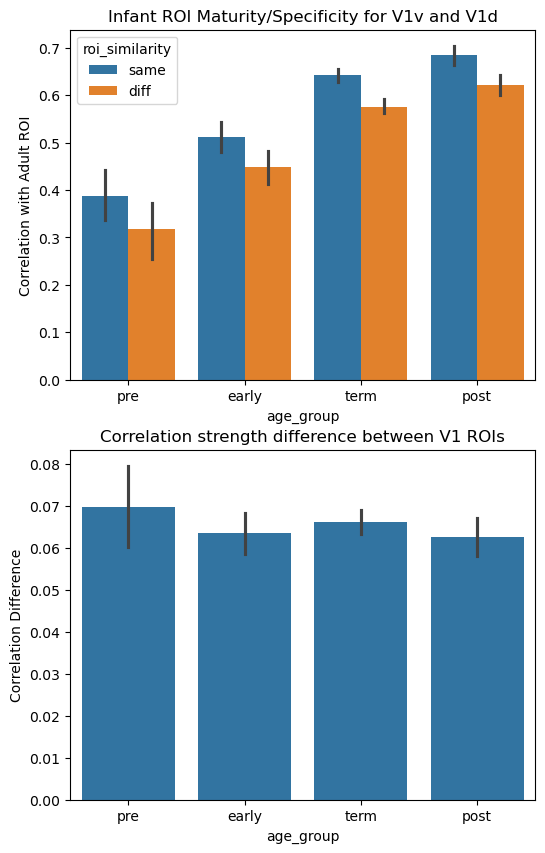

In [73]:
#plot by age group with same and diff as hue


#create a 2 plot subplot
fig, ax = plt.subplots(2, figsize=(6, 10))


plt.title('Infant ROI Similarity')

#make age group categorical
df_roi['age_group'] = pd.Categorical(df_roi['age_group'], categories=age_groups, ordered=True)
#make roi_similarity categorical
df_roi['roi_similarity'] = pd.Categorical(df_roi['roi_similarity'], categories=['same', 'diff'], ordered=True)
#make age group categorical
df_roi_pivot['age_group'] = pd.Categorical(df_roi_pivot['age_group'], categories=age_groups, ordered=True)

#create a bar plot with age group on x axis and corr on y axis, add to first subplot
sns.barplot(x='age_group', y='corr', hue='roi_similarity', data=df_roi, ax = ax[0])
ax[0].set_title('Infant ROI Maturity/Specificity for V1v and V1d')
plt.legend(title='ROI Similarity', loc='upper left')
#change y axis title
ax[0].set_ylabel('Correlation with Adult ROI')


#plot diff as a function of age group
sns.barplot(x='age_group', y='diff', data=df_roi_pivot, ax =ax[1])
#add title to subplot
ax[1].set_title('Correlation strength difference between V1 ROIs')
#remove legend
ax[1].legend().remove()
#change y axis title
ax[1].set_ylabel('Correlation Difference')

In [74]:
infant_df = pd.read_csv(f'{group_params.out_dir}/derivatives/{atlas}/infant_{atlas}_roi_similarity.csv')

#add age group column
infant_df['age_group'] = np.nan
for i in range(len(age_bins)-1):
    infant_df.loc[(infant_df['scan_age'] >= age_bins[i]) & (infant_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]

#extract data where roi1 is V1v or V1d and roi2 is V1v or V1d
df_infant_roi = infant_df[(infant_df['roi1'].isin(['V1v', 'V1d'])) & (infant_df['roi2'].isin(['V1v', 'V1d']))]

#extract where hemi_similarity = diff
df_infant_roi = df_infant_roi[df_infant_roi['hemi_similarity'] == 'diff']

#group by roi_similarity
df_infant_roi = df_infant_roi.groupby(['sub','ses','age_group','roi_similarity'])['fc'].mean().reset_index()
#pivot roi_similarity keeping sub and age group and splittying corr by roi_similarity
df_infant_roi_pivot = df_infant_roi.pivot_table(index=['sub','ses','age_group'], columns='roi_similarity', values='fc').reset_index()
#create diff column
df_infant_roi_pivot['diff'] = df_infant_roi_pivot['same'] - df_infant_roi_pivot['diff']

/tmp/ipykernel_931992/159910654.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'pre' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  infant_df.loc[(infant_df['scan_age'] >= age_bins[i]) & (infant_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Correlation Difference')

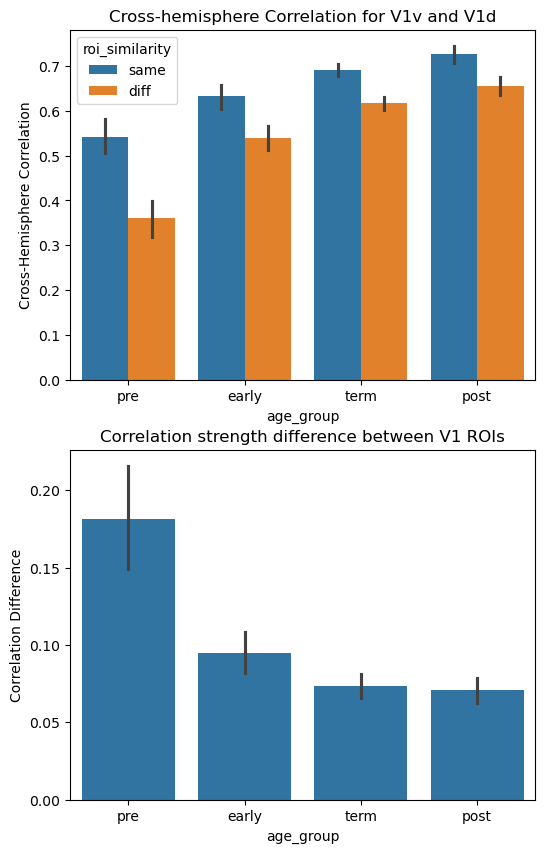

In [75]:
df_roi = df_infant_roi
df_roi_pivot = df_infant_roi_pivot

#make age group categorical
df_roi['age_group'] = pd.Categorical(df_roi['age_group'], categories=age_groups, ordered=True)
#make roi_similarity categorical
df_roi['roi_similarity'] = pd.Categorical(df_roi['roi_similarity'], categories=['same', 'diff'], ordered=True)
#make age group categorical
df_roi_pivot['age_group'] = pd.Categorical(df_roi_pivot['age_group'], categories=age_groups, ordered=True)
#make diff categorical
#df_roi_pivot['diff'] = pd.Categorical(df_roi_pivot['diff'], categories=['same', 'diff'], ordered=True)

#create a 2 plot subplot
fig, ax = plt.subplots(2, figsize=(6, 10))


plt.title('Infant ROI Similarity')

#make age group categorical
df_roi['age_group'] = pd.Categorical(df_roi['age_group'], categories=age_groups, ordered=True)
#make roi_similarity categorical
df_roi['roi_similarity'] = pd.Categorical(df_roi['roi_similarity'], categories=['same', 'diff'], ordered=True)

#create a bar plot with age group on x axis and corr on y axis, add to first subplot
sns.barplot(x='age_group', y='fc', hue='roi_similarity', data=df_roi, ax = ax[0])
ax[0].set_title('Cross-hemisphere Correlation for V1v and V1d')
plt.legend(title='ROI Similarity', loc='upper left')
#change y axis title
ax[0].set_ylabel('Cross-Hemisphere Correlation')


#plot diff as a function of age group
sns.barplot(x='age_group', y='diff', data=df_roi_pivot, ax =ax[1])
#add title to subplot
ax[1].set_title('Correlation strength difference between V1 ROIs')
#remove legend
ax[1].legend().remove()
#change y axis title
ax[1].set_ylabel('Correlation Difference')

In [ ]:
print(atlas.header)

In [ ]:
#glob all nifti files in dwi_bedpostx.bedpostX dir
bedpostx_dir = f'{group_info.out_dir}/{sub}/{ses}/dwi_bedpostx.bedpostX'
bedpostx_files = glob(f'{bedpostx_dir}/*.nii.gz')

In [ ]:
#loop through files and remake them with dwi header
for file in bedpostx_files:
    img = image.load_img(file)
    
    new_img = image.new_img_like(dwi, img.get_fdata(), affine = dwi.affine, copy_header = True)

    new_img.to_filename(file)
    

In [ ]:
#create new image_like dwi and add atlas data to it
atlas_new = image.new_img_like(dwi, atlas.get_fdata(), affine = dwi.affine, copy_header = True)

#save
atlas_new.to_filename(f'{group_info.out_dir}/{sub}/{ses}/atlas/Wang_maxprob_surf_lh_edits_dwi_bin.nii.gz')





In [ ]:
print(atlas_new.header)

In [ ]:
nodif_header = dwi.header

print(nodif_header)

In [ ]:
roi_header = roi.header
print(roi_header)

In [ ]:
sub = 'sub-CC00056XX07'
ses = 'ses-10700'

anat_dir = f'{params.raw_anat_dir}/{sub}/{ses}/anat'
func_dir = f'{params.raw_func_dir}/{sub}/{ses}func'
out_dir = f'{params.out_dir}/{sub}/{ses}'
roi_dir = f'{out_dir}/rois/'
#load anatomical
anat_img = image.load_img(f'{anat_dir}/{sub}_{ses}_{params.anat_suf}.nii.gz')
#load functional
func_img = image.load_img(f'{params.out_dir}/{sub}/{ses}/func/{sub}_{ses}_{params.func_suf}_1vol.nii.gz')

stat_img = image.load_img(f'{out_dir}/derivatives/thalmocortical/rh_IPS0_second_order_anat.nii.gz')


In [ ]:
#loop through rois and load them


for hemi in ['lh','rh']:
    roi_imgs = []

    
    for roi in roi_labels['label']:
        roi_imgs.append(image.load_img(f'{roi_dir}/{hemi}_{roi}_epi.nii.gz').get_fdata())

    #create a zeros array with the same shape as the functional image
    zero_imgs = np.zeros(func_img.shape)  
    #insert zeros array as the first element of the roi_imgs list
    roi_imgs.insert(0, zero_imgs)
    #conert to numpy array
    roi_imgs = np.array(roi_imgs)
    #insert zeros array as the first element of the roi_imgs array
    

    #for every voxel, get the index of the max value
    max_roi = np.argmax(roi_imgs, axis=0)
    #add 1 to the index to get the roi label
    
    #convert max_roi to nifti
    max_roi = nib.Nifti1Image(max_roi, func_img.affine, func_img.header)

    #save it
    nib.save(max_roi, f'{out_dir}/atlas/Wang_maxprob_surf_{hemi}_edits_epi.nii.gz')


#### Adult


In [ ]:
sub = 'sub-104416'
ses = 'ses-01'
#load anatomical
anat_img = image.load_img(f'{params.out_dir}/{sub}/{ses}/anat/{sub}_{ses}_{params.anat_suf}.nii.gz')
#load functional
func_img = image.load_img(f'{params.raw_func_dir}/{sub}/{ses}/func/{sub}_{ses}_{params.func_suf}.nii.gz')
func_dir = f'{params.raw_func_dir}/{sub}/{ses}'
out_dir = f'{params.out_dir}/{sub}/{ses}'
roi_dir = f'{out_dir}/rois/{atlas}'

roi_img = image.load_img(f'{roi_dir}/lh_V1v_epi.nii.gz')

atlas_dir = f'{out_dir}/atlas/Wang_maxprob_surf_lh_edits_epi.nii'